## Ocean examples

This tutorial shows how to use 2D oceanfields (from satellite or model outputs) to advect numerical particles.
    
A particular attention should be paid to
u,v input format:
u(time,x,y)
    
u and v should also be converted into deg/day unit.
    
Inputs:
- all_days: list of dates for velocity fields to be  load in object "field" (format ['YYYYmmdd'])
- rep: directory path of netcdf data files
- varn: dictionnary with variable names as they are stored in netcdf file varn = {varn = {'longitude':'XXX','latitude':'XXX','u':'XXX','v':'XXX'}}
- unit: unit for u,v outputs ('cm/s' or 'deg/d')

See Load_nc.py for more details.

### import necessary librairies

In [1]:
from lamta.Diagnostics import ParticleSet, Lagrangian
from lamta.Load_nc import loadCMEMSuv

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Load field from satellite data

In [2]:
from pathlib import Path
import numpy as np

from lamta_examples.data_fetch import ensure_dataset
from lamta.Load_nc import loadCMEMSuv

DATA_DIR = Path(
    ensure_dataset("altimetry_nrt_global_20220909-20220929.tar.gz")
)

rep = str(DATA_DIR / "altimetry" / "nrt_global") + "/"


all_days = ['20220919','20220920','20220921','20220922','20220923','20220924','20220925','20220926','20220927','20220928','20220929']

varn = {'longitude':'longitude','latitude':'latitude','u':'ugos','v':'vgos'}
field = loadCMEMSuv(all_days,rep,varn,unit='deg/d')
print(field['lon'])
#check u shape (time,x,y)
print(np.shape(field['u']))

[-179.875 -179.625 -179.375 ...  179.375  179.625  179.875]
(11, 1440, 720)


In [3]:
# Set initial particle on regular grid field object is saved in pset object 
#(see ParticleSet.ipynb)
numdays = 10
loni = [4.5,6.5]
lati = [41.5,43.5]
delta0 = 0.5
dayv = '2022-09-29'
pset = ParticleSet.from_grid(numdays,loni,lati,delta0,dayv,fieldset=field)

In [4]:
## Trajectories advected with RK4 using ocean field
# default advection is backward (see Advection.ipynb)
numstep = 20
# for ocean experiment coordinates must be spherical 
trjf = pset.rk4flat(Lagrangian.interpf,numstep,coordinates='spherical')
print(trjf['lons']) #initial longitudes

[4.5 5.  5.5 6. ]


c:\Users\lloyd\miniforge3\envs\lamta_examples\Lib\site-packages\shapely\creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
c:\Users\lloyd\miniforge3\envs\lamta_examples\Lib\site-packages\shapely\creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
c:\Users\lloyd\miniforge3\envs\lamta_examples\Lib\site-packages\shapely\creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
c:\Users\lloyd\miniforge3\envs\lamta_examples\Lib\site-packages\shapely\creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
c:\Users\lloyd\miniforge3\envs\lamta_examples\Lib\site-packages\shapely\creation.py:218: RuntimeWarning: invalid value encou

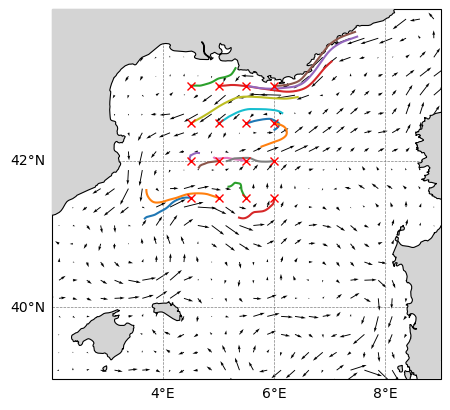

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import MultipleLocator

lat = np.asarray(field["lat"])
lon = np.asarray(field["lon"])
Y, X = np.meshgrid(lat, lon)  # shapes: (nlon, nlat)  <-- same as your Basemap code

u0 = np.asarray(field["u"][0, :, :])
v0 = np.asarray(field["v"][0, :, :])

if u0.shape != X.shape:
    if u0.T.shape == X.shape:
        u0 = u0.T
        v0 = v0.T
    else:
        raise ValueError(f"Cannot align u/v with grid: grid={X.shape}, u0={u0.shape}")

fig = plt.figure()
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([2, 9, 39, 44], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor="0.83", edgecolor="none", zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=101)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, linestyle="--", color="0.5")
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = MultipleLocator(2)
gl.ylocator = MultipleLocator(2)

skip = 1
ax.quiver(
    X[::skip, ::skip], Y[::skip, ::skip],
    u0[::skip, ::skip], v0[::skip, ::skip],
    transform=ccrs.PlateCarree(),
    scale=5,
    color="k",
    zorder=1,
)

trjx = np.asarray(trjf["trjx"])
trjy = np.asarray(trjf["trjy"])

# Ensure (ntime, ntraj) using the *real* ntime from your list-of-steps structure
ntime = len(trjf["trjx"]) if isinstance(trjf["trjx"], (list, tuple)) else None
if ntime is not None and trjx.ndim == 2 and trjx.shape[0] != ntime and trjx.shape[1] == ntime:
    trjx = trjx.T
    trjy = trjy.T

ax.plot(trjx, trjy, transform=ccrs.PlateCarree(), zorder=102)
ax.plot(trjx[0, :], trjy[0, :], "rx", transform=ccrs.PlateCarree(), zorder=103)

plt.savefig("../outputs/ocean_example.png", dpi=200, bbox_inches="tight")
plt.show()


In [6]:
# Another example: Fill all domain with initial particles
numdays = 10
loni = [2,8.5]
lati = [39.5,44]
delta0 = 0.5
dayv = '2022-09-29'
pset = ParticleSet.from_grid(numdays,loni,lati,delta0,dayv,fieldset=field)
trjf = pset.rk4flat(Lagrangian.interpf,numstep,coordinates='spherical')

c:\Users\lloyd\miniforge3\envs\lamta_examples\Lib\site-packages\shapely\creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
c:\Users\lloyd\miniforge3\envs\lamta_examples\Lib\site-packages\shapely\creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
c:\Users\lloyd\miniforge3\envs\lamta_examples\Lib\site-packages\shapely\creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
c:\Users\lloyd\miniforge3\envs\lamta_examples\Lib\site-packages\shapely\creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
c:\Users\lloyd\miniforge3\envs\lamta_examples\Lib\site-packages\shapely\creation.py:218: RuntimeWarning: invalid value encou

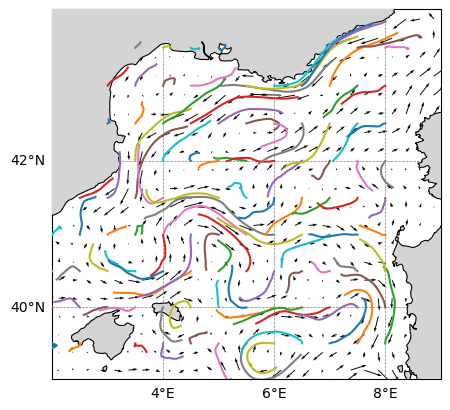

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import MultipleLocator

fig = plt.figure()
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([2, 9, 39, 44], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor="0.83", edgecolor="none", zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=101)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, linestyle="--", color="0.5")
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = MultipleLocator(2)
gl.ylocator = MultipleLocator(2)

lon = np.asarray(field["lon"])
lat = np.asarray(field["lat"])
u0 = np.asarray(field["u"][0, :, :])
v0 = np.asarray(field["v"][0, :, :])

# Build lon/lat grids that match u0/v0
if u0.shape == (lat.size, lon.size):
    Lon, Lat = np.meshgrid(lon, lat)  # (nlat, nlon)
elif u0.shape == (lon.size, lat.size):
    Lon, Lat = np.meshgrid(lon, lat, indexing="ij")  # (nlon, nlat)
else:
    raise ValueError(f"Unexpected u0 shape {u0.shape}")

skip = 1
ax.quiver(
    Lon[::skip, ::skip], Lat[::skip, ::skip],
    u0[::skip, ::skip],  v0[::skip, ::skip],
    transform=ccrs.PlateCarree(),
    scale=5,
    color="k",
    zorder=1,
)

x = np.asarray(trjf["trjx"])
y = np.asarray(trjf["trjy"])

ntime = len(trjf["trjx"]) if isinstance(trjf["trjx"], (list, tuple)) else None
if ntime is not None and x.ndim == 2 and x.shape[0] != ntime and x.shape[1] == ntime:
    x = x.T
    y = y.T

ax.plot(x, y, transform=ccrs.PlateCarree(), zorder=102)

plt.show()
